In [1]:
import sys
import numpy as np
import spectral as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import torch

sys.path.append('../')
from preprocessing import *
from extinctions import *
from plotting_parameters import *
set_plotting_style('latex')

### Load Spectral Data

from literature

In [2]:
bands_range = [520,900]
band_centers = np.arange(bands_range[0], bands_range[1]+1)

extinction_dict = get_extinctions(bands_range)
cyt_c_ox = extinction_dict["cyt_c_ox"]
cyt_c_red = extinction_dict["cyt_c_red"]
cyt_b_ox = extinction_dict["cyt_b_ox"]
cyt_b_red = extinction_dict["cyt_b_red"]
cyt_oxi_ox = extinction_dict["cyt_oxi_ox"]
cyt_oxi_red = extinction_dict["cyt_oxi_red"]
hb = extinction_dict["hb"]
hbo2 = extinction_dict["hbo2"]
water = extinction_dict["water"]
fat = extinction_dict["fat"]
ones = np.ones_like(water)
scatter_simple = (band_centers/500)**(-1.2)

# remove cytochrome difference spectra as they are not needed for helicoid
_ = extinction_dict.pop("cyt_c_diff")
_ = extinction_dict.pop("cyt_b_diff")
_ = extinction_dict.pop("cyt_oxi_diff")

endmember_labels_scatter = ["oxCytc", "redCytc", "oxCytb", "redCytb", "oxCCO", "redCCO", "HHb", "HbO$_2$", "water", "lipids", "a'"]
M_scatter_simple = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, scatter_simple)).T
M_lit = smooth_spectral(M_scatter_simple.T,5).T


from MC simulations

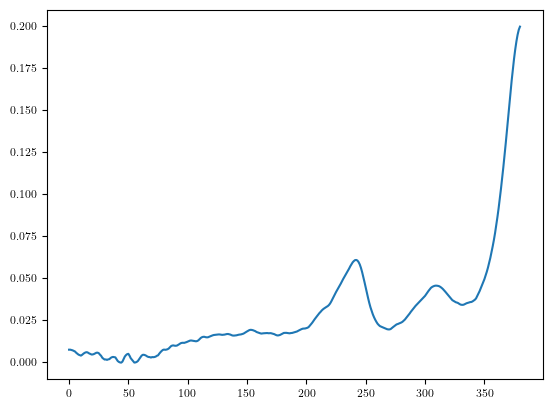

In [7]:
spectra_folder = "../mc_sim/spectra_mc/"

hb_mc = np.loadtxt(spectra_folder + "m_hhb_50.txt")
hbo2_mc = np.loadtxt(spectra_folder + "m_hbo2_50.txt")
cyt_c_ox_mc = np.loadtxt(spectra_folder + "m_cyt_c_ox_20.txt")
cyt_c_red_mc = np.loadtxt(spectra_folder + "m_cyt_c_red_20.txt")
cyt_b_ox_mc = np.loadtxt(spectra_folder + "m_cyt_b_ox_20.txt")
cyt_b_red_mc = np.loadtxt(spectra_folder + "m_cyt_b_red_20.txt")
cyt_oxi_ox_mc = np.loadtxt(spectra_folder + "m_cyt_oxi_ox_20.txt")
cyt_oxi_red_mc = np.loadtxt(spectra_folder + "m_cyt_oxi_red_20.txt")
scatter_mc = np.loadtxt(spectra_folder + "m_scatter_40.txt")
water_mc = np.loadtxt(spectra_folder + "m_water_200.txt")
fat_mc = np.loadtxt(spectra_folder + "m_fat_200.txt")

M_mc = np.vstack((cyt_c_ox_mc, cyt_c_red_mc, cyt_b_ox_mc, cyt_b_red_mc, cyt_oxi_ox_mc, cyt_oxi_red_mc, hb_mc, hbo2_mc, water_mc, fat_mc, scatter_mc)).T
M_mc = smooth_spectral(M_mc.T,5).T

plt.plot(M_mc[:,-2])

In [8]:
class_labels = ["Not labled", "Normal", "Tumor", "Blood", "Background"]
def osp_processing(absorbance, M, filename=None, plot_hm=False, gt_map=None):
    data = np.zeros((*absorbance.shape[:-1],11))
    for i in range(11):
        endmembers_remove = np.delete(M, i, axis=1).T
        endmember_target = M[:,i]
        data[...,i] = osp(absorbance, endmembers_remove, endmember_target)
    if filename is not None:
        np.save(os.path.join("../../datasets/npj_database",filename), data)

    if gt_map is not None:
        fig_tsne, _ = plot_tsne(data, gt_map, class_labels, mode='equal', figsize=(2.8,2.5), legend_loc=None)
    if plot_hm:
        fig_heatmaps, _ = plot_concentrations(clip_data(data), endmember_labels_scatter, figsize=(5.8,2.3));

        plot_concentrations(clip_data(data[250:350,50:150]), endmember_labels_scatter, figsize=(15,8));
    
    if (gt_map is not None) and plot_hm:
        return fig_tsne, fig_heatmaps
    elif gt_map is not None:
        return fig_tsne
    elif plot_hm:
        return fig_heatmaps
    

def osp_heatmaps(absorbance, M):
    m = M.shape[1]
    data = np.zeros((*absorbance.shape[:-1],m))
    for i in range(m):
        endmembers_remove = np.delete(M, i, axis=1).T
        endmember_target = M[:,i]
        data[...,i] = osp(absorbance, endmembers_remove, endmember_target)
    return data

#### Cosine similarity without projection

In [30]:
img_id = "012-01"
data_folder = f"../../datasets/npj_database/{img_id}"
absorbance = np.load(data_folder + "/preprocessed.npy")
gt_map = sp.open_image(data_folder + "/gtMap.hdr").asarray()
img_raw = sp.open_image(data_folder + "/raw.hdr").asarray()

normal_idxs = np.where(gt_map == 1)
ref_absorbance = absorbance[normal_idxs[0][0],normal_idxs[1][0]]
rel_absorbance = absorbance - ref_absorbance

/home/martin_ivan/anaconda3/envs/thesis/lib/python3.10/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [19]:
figsize_heatmaps = (5.8,2.3)

# m = M.shape[1]
# data = np.zeros((absorbance.shape[0],absorbance.shape[1],m))
# for i in range(m):
#     data[:,:,i] = similarity(absorbance_osp, M[:,i])

# plot_tsne(data, gt_map, class_labels, mode='equal', figsize=(2.8,2.5), legend_loc=None)
# plot_concentrations(clip_data(data), endmember_labels_scatter, figsize=figsize_heatmaps);

tests with different spectra configurations

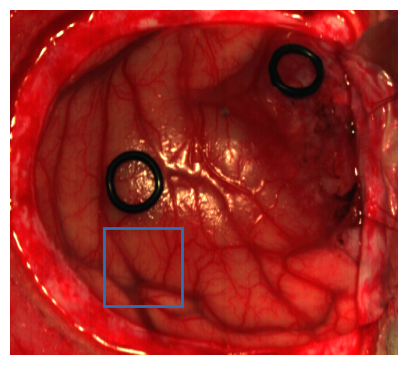

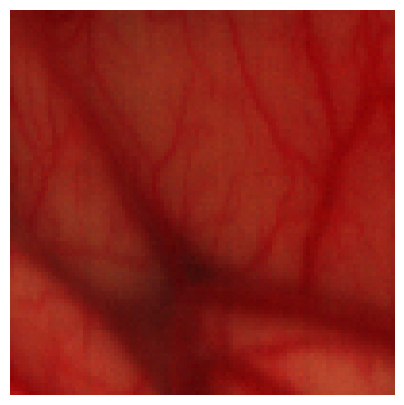

In [9]:
# M_mixed_hb = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb_mc, hbo2_mc, water_mc, fat_mc, scatter_mc)).T
# M_mixed_hb = smooth_spectral(M_mixed_hb.T,5).T

# data_orig = osp_heatmaps(rel_absorbance, M_lit)
# data_mixed = osp_heatmaps(rel_absorbance, M_mixed_hb)
# data_mc = osp_heatmaps(rel_absorbance, M_mc)

img_raw = sp.open_image('../../datasets/helicoid/012-01/raw.hdr').asarray()
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(get_rgb(img_raw))
rect1 = mpl.patches.Rectangle((120,280), 100, 100, linewidth=2, edgecolor=tum_blue_brand, facecolor='none')
ax.add_patch(rect1)
# rect2 = mpl.patches.Rectangle((320,100), 100, 100, linewidth=2, edgecolor=tum_blue_brand, facecolor='none')
# ax.add_patch(rect2)
ax.axis('off')
fig.savefig("../../figures/zoom_regions_marked_12-01.png", dpi=600, bbox_inches='tight')

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(get_rgb(img_raw)[280:380,120:220], cmap='hot')
ax.axis('off')
fig.savefig("../../figures/srgb_zoom1_12-01.png", dpi=600, bbox_inches='tight')

# # HHb
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_orig[:,:,6]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/HHb_literature_12-01.png", dpi=600, bbox_inches='tight')
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_orig[280:380,120:220,6]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/HHb_literature_zoom1_12-01.png", dpi=600, bbox_inches='tight')
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_orig[100:200,320:420,6]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/HHb_literature_zoom2_12-01.png", dpi=600, bbox_inches='tight')

# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_mixed[:,:,6]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/HHb_mixed_12-01.png", dpi=600, bbox_inches='tight')
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_mixed[280:380,120:220,6]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/HHb_mixed_zoom1_12-01.png", dpi=600, bbox_inches='tight')
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_mixed[100:200,320:420,6]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/HHb_mixed_zoom2_12-01.png", dpi=600, bbox_inches='tight')

# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_mc[:,:,6]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/HHb_mc_12-01.png", dpi=600, bbox_inches='tight')
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_mc[280:380,120:220,6]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/HHb_mc_zoom1_12-01.png", dpi=600, bbox_inches='tight')
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_mc[100:200,320:420,6]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/HHb_mc_zoom2_12-01.png", dpi=600, bbox_inches='tight')

# # HbO2
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_orig[:,:,7]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/Hbo2_literature_12-01.png", dpi=600, bbox_inches='tight')
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_orig[280:380,120:220,7]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/Hbo2_literature_zoom1_12-01.png", dpi=600, bbox_inches='tight')
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_orig[100:200,320:420,7]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/Hbo2_literature_zoom2_12-01.png", dpi=600, bbox_inches='tight')

# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_mixed[:,:,7]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/Hbo2_mixed_12-01.png", dpi=600, bbox_inches='tight')
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_mixed[280:380,120:220,7]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/Hbo2_mixed_zoom1_12-01.png", dpi=600, bbox_inches='tight')
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_mixed[100:200,320:420,7]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/Hbo2_mixed_zoom2_12-01.png", dpi=600, bbox_inches='tight')

# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_mc[:,:,7]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/Hbo2_mc_12-01.png", dpi=600, bbox_inches='tight')
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_mc[280:380,120:220,7]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/Hbo2_mc_zoom1_12-01.png", dpi=600, bbox_inches='tight')
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.imshow(clip_data(data_mc[100:200,320:420,7]), cmap='hot')
# ax.axis('off')
# fig.savefig("../../figures/Hbo2_mc_zoom2_12-01.png", dpi=600, bbox_inches='tight')


### Linear Mixture Model

In [7]:
for img_id in ['008-01']:#,'012-01','020-01','038-01','039-01','043-01']:
    # data_folder = f"../../datasets/npj_database/{img_id}"
    data_folder = f"../../datasets/helicoid/{img_id}"
    absorbance = np.load(data_folder + "/preprocessed.npy")
    gt_map = sp.open_image(data_folder + "/gtMap.hdr").asarray()
    img_raw = sp.open_image(data_folder + "/raw.hdr").asarray()

    normal_idxs = np.where(gt_map == 1)
    ref_absorbance = absorbance[normal_idxs[0][0],normal_idxs[1][0]]
    rel_absorbance = absorbance - ref_absorbance


    # fig_tsen, fig_heatmaps = osp_processing(absorbance, M_lit, filename=None, plot_hm=True, gt_map=gt_map);
    # fig_heatmaps.savefig(f"../../figures/osp_heatmaps_{img_id}.svg", bbox_inches='tight', dpi=600, format='svg')

    # fig_tsen, fig_heatmaps = osp_processing(rel_absorbance, M_lit, filename=None, plot_hm=True, gt_map=gt_map);
    # fig_heatmaps.savefig(f"../../figures/osp_heatmaps_rel_{img_id}.svg", bbox_inches='tight', dpi=600, format='svg')

    fig_tsen, fig_heatmaps = osp_processing(rel_absorbance, M_mc, filename=None, plot_hm=True, gt_map=gt_map);
    # fig_heatmaps.savefig(f"../../figures/osp_heatmaps_rel_mc{img_id}.svg", bbox_inches='tight', dpi=600, format='svg')

FileNotFoundError: [Errno 2] No such file or directory: '../../datasets/helicoid/008-01/preprocessed.npy'

### Bilinear Mixture Model

In [ ]:
M = M_lit
absorbance_osp = absorbance

Removing all bilinear terms

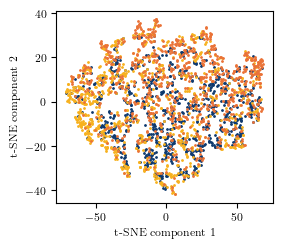

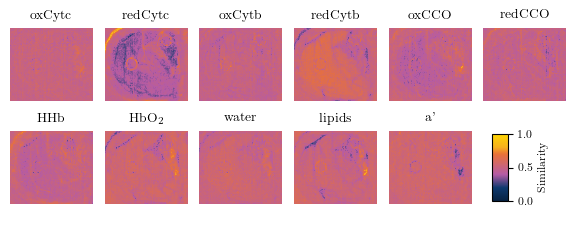

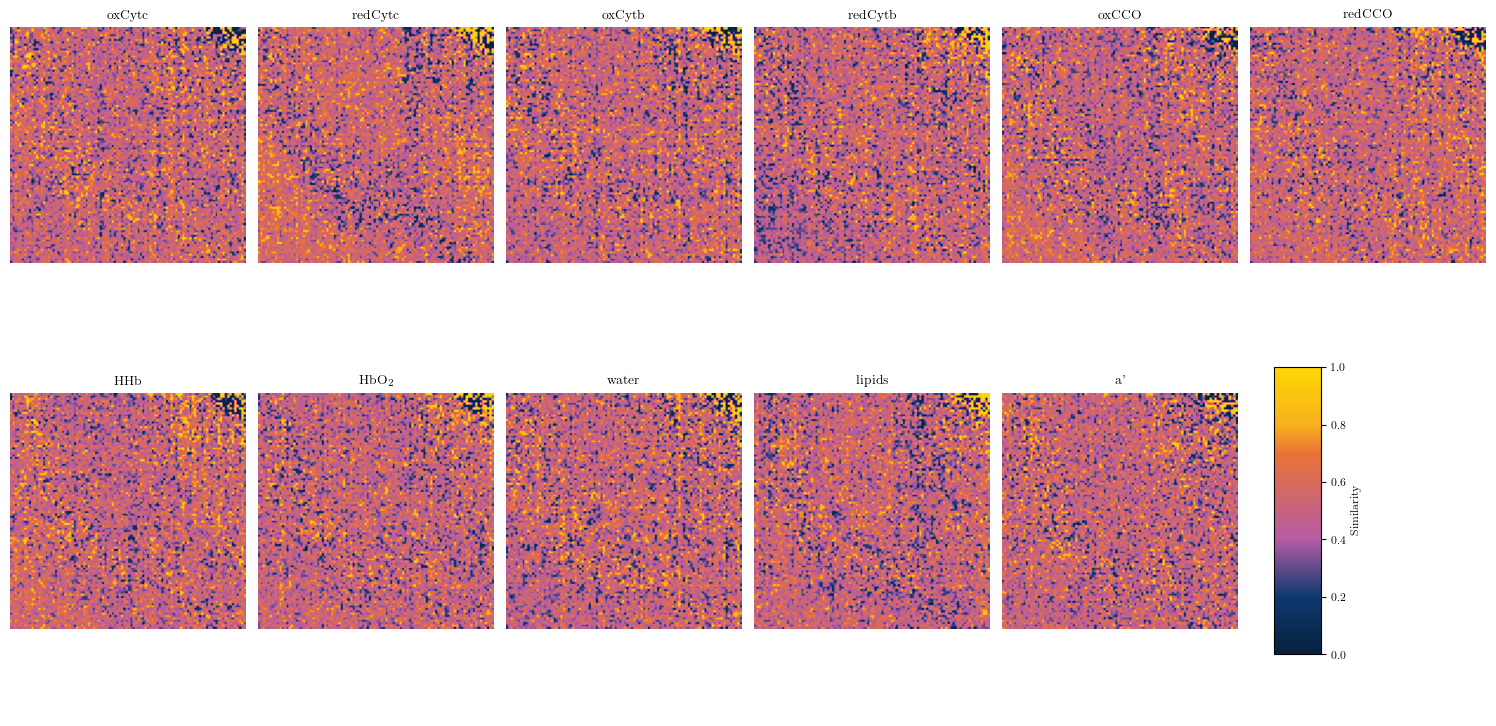

In [20]:
k,n = M.shape
M_bilinear = np.zeros((k,int(n*(n+1)/2)+11))
M_bilinear[:,:11] = M
idx = 11
for i in range(n):
    for j in range(i,n):
        M_bilinear[:,idx] = M[:,i] * M[:,j]
        idx += 1

fig_tsne, fig_heatmaps = osp_processing(absorbance_osp, M_bilinear, gt_map=gt_map, filename=None, plot_hm=True);
fig_heatmaps.savefig(f"../../figures/osp_heatmaps_bilin_all_{img_id}.svg", bbox_inches='tight', dpi=600)

considering only bilinear water part

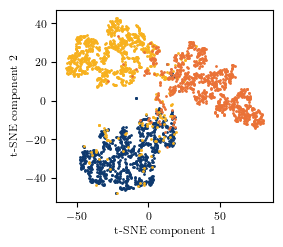

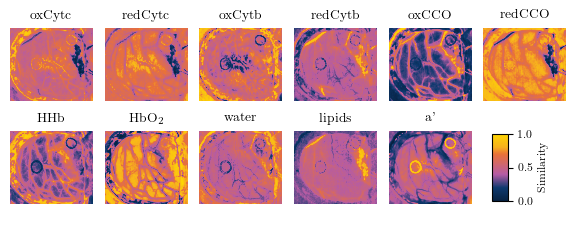

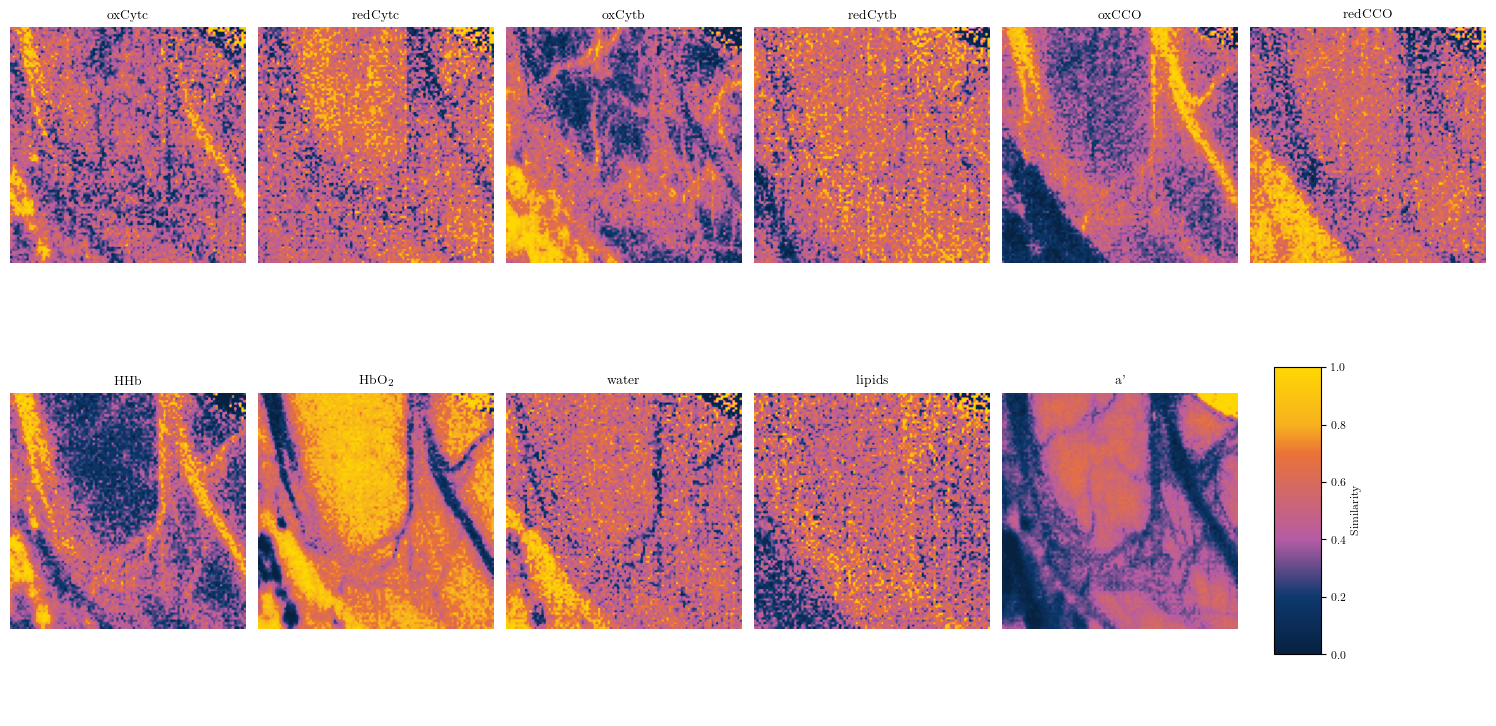

In [21]:
k,m = M.shape
M_bilinear_water = np.zeros((k,11*2))
M_bilinear_water[:,:11] = M
idx = 11
for i in range(m):
    M_bilinear_water[:,idx] = M[:,i] * smooth_spectral(water,5)
    idx += 1

fig_tsne, fig_heatmaps = osp_processing(absorbance_osp, M_bilinear_water, gt_map=gt_map, filename=None, plot_hm=True);
fig_heatmaps.savefig(f"../../figures/osp_heatmaps_bilin_water_{img_id}.svg", bbox_inches='tight', dpi=600)

considering hemoglobin bilinear terms with cytochromes

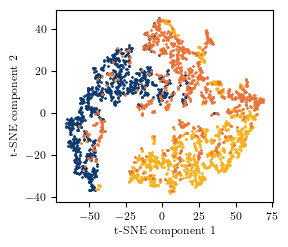

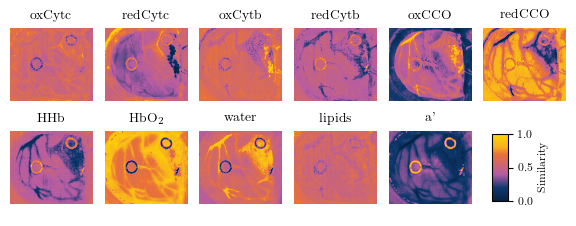

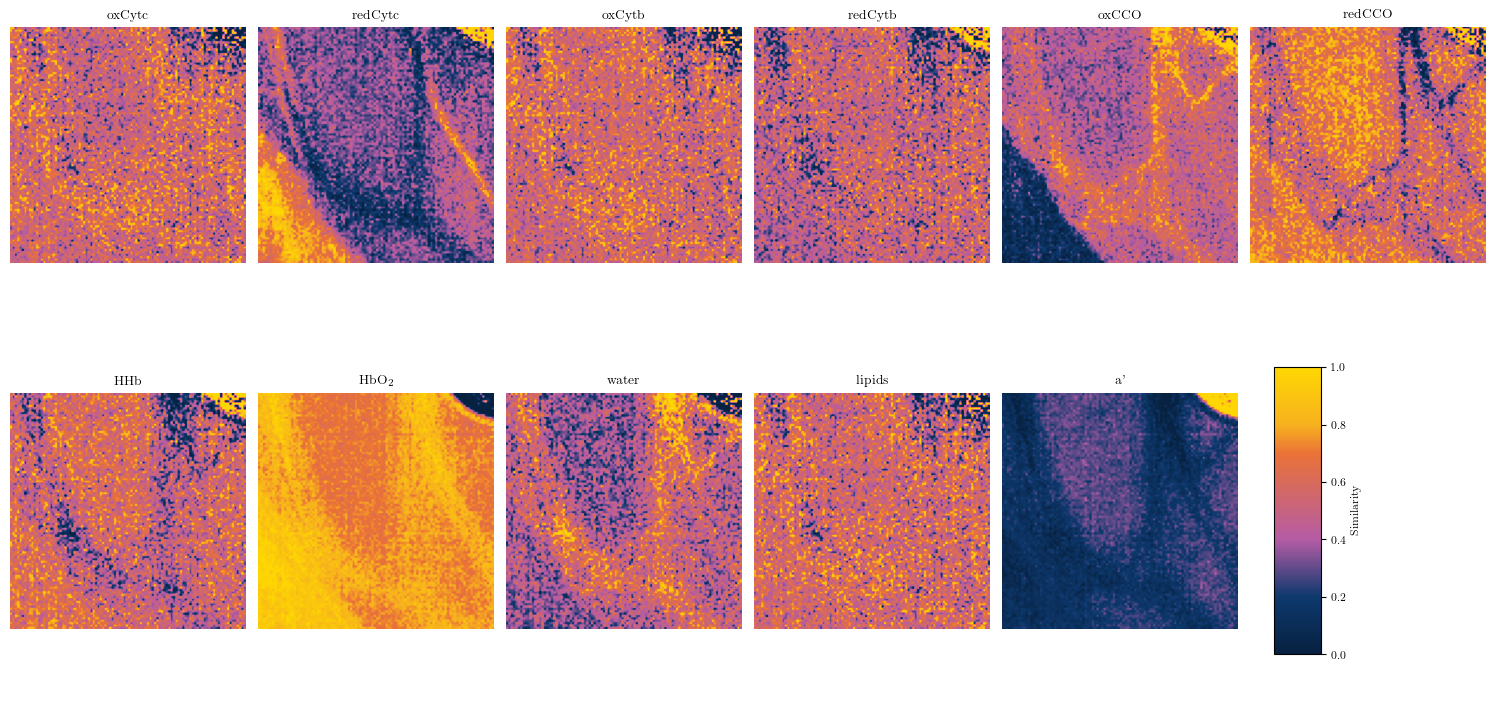

In [22]:
M_bilinear_hem = np.zeros((k,11*3))
M_bilinear_hem[:,:11] = M
idx = 11
for i in range(6):
    M_bilinear_hem[:,idx] = M[:,i] * smooth_spectral(hb,5)
    M_bilinear_hem[:,idx+1] = M[:,i] * smooth_spectral(hbo2,5)
    idx += 2

fig_tsne, fig_heatmaps = osp_processing(absorbance_osp, M_bilinear_hem, gt_map=gt_map, filename=None, plot_hm=True);
fig_heatmaps.savefig(f"../../figures/osp_heatmaps_bilin_hem_{img_id}.svg", bbox_inches='tight', dpi=600)

### Run tests on whole dataset

In [15]:
database_folder = "../../datasets/npj_database"
absorbance_all = []
rel_absorbance_all = []
labels_all = []
print(os.listdir(database_folder))
for img_folder in os.listdir(database_folder):
    if img_folder in ['058-02','055-02','053-01','051-01','056-02','054-01','056-01','055-01','057-01','050-01']:
        print(f"Skipping {img_folder}")
        continue
    if os.path.isdir(os.path.join(database_folder,img_folder)):
        img_absorbance = np.load(os.path.join(database_folder,img_folder,"preprocessed.npy"))
        img_gt_map = sp.open_image(os.path.join(database_folder,img_folder,"gtMap.hdr")).asarray().squeeze()

        normal_idxs = np.where(img_gt_map == 1)
        if len(normal_idxs[0]) == 0:
            continue
        absorbance_all.append(img_absorbance[img_gt_map != 0])
        labels_all.append(img_gt_map[img_gt_map != 0])
        ref_absorbance = img_absorbance[normal_idxs[0][0],normal_idxs[1][0]]
        rel_absorbance_all.append(img_absorbance[img_gt_map != 0] - ref_absorbance)

absorbance_all = np.concatenate(absorbance_all, axis=0) 
rel_absorbance_all = np.concatenate(rel_absorbance_all, axis=0)
labels_all = np.concatenate(labels_all, axis=0)

['020-01', '021-05', '010-03', '022-03', '007-01', '018-02', '015-01', '041-01', '037-02', '040-01', '036-02', '017-01', '058-02', '035-02', '036-01', '055-02', '016-05', '039-02', '012-02', '016-02', '053-01', '008-02', '042-03', '004-02', '018-01', '042-02', '034-03', '051-01', '034-01', '056-02', '054-01', '016-01', '043-04', '005-01', '008-01', '039-01', '016-04', '056-01', '021-01', '012-01', '042-01', '037-04', '019-01', '034-02', '043-01', '013-01', '022-01', '037-01', '021-02', '043-02', '038-01', '055-01', '014-01', '016-03', '022-02', '037-03', '041-02', '057-01', '040-02', '035-01', '050-01']


/home/martin_ivan/anaconda3/envs/thesis/lib/python3.10/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Skipping 058-02
Skipping 055-02
Skipping 053-01
Skipping 051-01
Skipping 056-02
Skipping 054-01
Skipping 056-01
Skipping 055-01
Skipping 057-01
Skipping 050-01


In [16]:
# select 5000 random pixels from each class
np.random.seed(0)
n = 5000
idxs = []
for i in range(1,4):
    idx = np.where(labels_all == i)[0]
    idxs.append(np.random.choice(idx,n,replace=False))
idxs = np.concatenate(idxs, axis=0)
absorbance_subset = absorbance_all[idxs]
rel_absorbance_subset = rel_absorbance_all[idxs]
labels_subset = labels_all[idxs]

Absolute absorbance

In [8]:
M = M_lit

k,m = M.shape
M_bilinear_water = np.zeros((k,11*2))
M_bilinear_water[:,:11] = M
idx = 11
for i in range(m):
    M_bilinear_water[:,idx] = M[:,i] * smooth_spectral(water,5)
    idx += 1

M_bilinear_hem = np.zeros((k,11*3))
M_bilinear_hem[:,:11] = M
idx = 11
for i in range(6):
    M_bilinear_hem[:,idx] = M[:,i] * smooth_spectral(hb,5)
    M_bilinear_hem[:,idx+1] = M[:,i] * smooth_spectral(hbo2,5)
    idx += 2

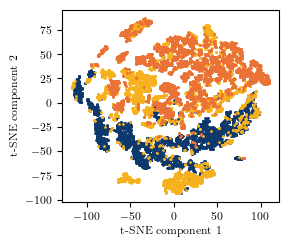

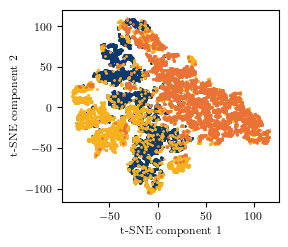

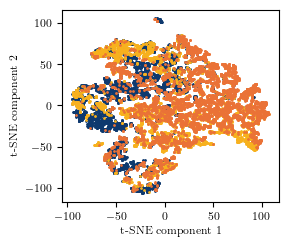

In [9]:
fig_tsne = osp_processing(absorbance_subset, M, filename=None, plot_hm=False, gt_map=labels_subset);
fig_tsne.savefig("../../figures/tsne_osp.svg", bbox_inches='tight', dpi=600)

fig_tsne = osp_processing(absorbance_subset, M_bilinear_water, filename=None, plot_hm=False, gt_map=labels_subset);
fig_tsne.savefig("../../figures/tsne_osp_blin_water.svg", bbox_inches='tight', dpi=600)

fig_tsne = osp_processing(absorbance_subset, M_bilinear_hem, filename=None, plot_hm=False, gt_map=labels_subset);
fig_tsne.savefig("../../figures/tsne_osp_blin_hem.svg", bbox_inches='tight', dpi=600)

Relative absorbance

In [12]:
M = M_mc

k,m = M.shape
M_bilinear_water = np.zeros((k,11*2))
M_bilinear_water[:,:11] = M
idx = 11
for i in range(m):
    M_bilinear_water[:,idx] = M[:,i] * smooth_spectral(water,5)
    idx += 1

M_bilinear_hem = np.zeros((k,11*3))
M_bilinear_hem[:,:11] = M
idx = 11
for i in range(6):
    M_bilinear_hem[:,idx] = M[:,i] * smooth_spectral(hb,5)
    M_bilinear_hem[:,idx+1] = M[:,i] * smooth_spectral(hbo2,5)
    idx += 2

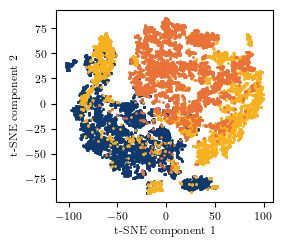

In [13]:
fig_tsne = osp_processing(rel_absorbance_subset, M, filename=None, plot_hm=False, gt_map=labels_subset);
fig_tsne.savefig("../../figures/tsne_osp_rel_mc.svg", bbox_inches='tight', dpi=600)

# fig_tsne = osp_processing(rel_absorbance_subset, M_bilinear_water, filename=None, plot_hm=False, gt_map=labels_subset);
# fig_tsne = osp_processing(rel_absorbance_subset, M_bilinear_hem, filename=None, plot_hm=False, gt_map=labels_subset);

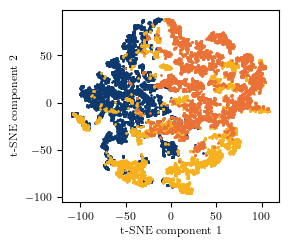

In [17]:
M_mixed_hb = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb_mc, hbo2_mc, water_mc, fat_mc, scatter_mc)).T
M_mixed_hb = smooth_spectral(M_mixed_hb.T,5).T
fig_tsne = osp_processing(rel_absorbance_subset, M_mixed_hb, filename=None, plot_hm=False, gt_map=labels_subset);

### Generate and save heatmaps

In [6]:
database_folder = "../../datasets/npj_database"
print(os.listdir(database_folder))
for img_folder in os.listdir(database_folder):
    if os.path.isdir(os.path.join(database_folder,img_folder)) and os.path.exists(os.path.join(database_folder,img_folder,"rel_absorbance.npy")):
        img_absorbance = np.load(os.path.join(database_folder,img_folder,"preprocessed.npy"))
        img_gt_map = sp.open_image(os.path.join(database_folder,img_folder,"gtMap.hdr")).asarray().squeeze()
        img_rel_absorbance = np.load(os.path.join(database_folder,img_folder,"rel_absorbance.npy"))

        osp_processing(img_absorbance, M_lit, filename=f'{img_folder}/osp_absolute.npy', plot_hm=False, gt_map=None)
        osp_processing(img_rel_absorbance, M_lit, filename=f'{img_folder}/osp_rel_lit.npy', plot_hm=False, gt_map=None)
        osp_processing(img_rel_absorbance, M_mc, filename=f'{img_folder}/osp_rel_mc.npy', plot_hm=False, gt_map=None)

['020-01', '021-05', '010-03', '022-03', '007-01', '018-02', '015-01', '041-01', '037-02', '040-01', '036-02', '017-01', '058-02', '035-02', '036-01', '055-02', '016-05', '039-02', '012-02', '016-02', '053-01', '008-02', '042-03', '004-02', '018-01', '042-02', '034-03', '051-01', '034-01', 'osp_absolute.npy', '056-02', 'osp_rel_lit.npy', '054-01', '016-01', '043-04', '005-01', '008-01', '039-01', '016-04', '056-01', '021-01', '012-01', '042-01', '037-04', '019-01', '034-02', '043-01', '013-01', '022-01', '037-01', '021-02', '043-02', '038-01', '055-01', '014-01', '016-03', '022-02', '037-03', '041-02', '057-01', '040-02', 'osp_rel_mc.npy', '035-01', '050-01']
